In [29]:
%matplotlib inline
import numpy as np
import matplotlib.pyplot as plt
import scipy.spatial
import scipy.optimize
import active
import monad
import seaborn as sns
sns.set_context('notebook')

## Run a simple simulation and make a movie of dynamics

In [21]:
# Simulation settings
n = 40
rho = 4.
eta = .5
vel = 0.03
rcut=.1
nframes = 500
nlog = 1
np.random.seed(100)

In [251]:
ptraj, ttraj = active.run(n, rho, eta, vel, rcut, nframes, nlog)

In [252]:
def plot_arrows(ptraj, start=0, stop=None, stride=1, dpi=100):
    if stop is None:
        stop = len(ptraj)
    for count, frameid in enumerate(range(start, stop, stride)):
        fig = plt.figure()
        ax = fig.add_subplot(111)
        X = ptraj[frameid][:,0]
        Y = ptraj[frameid][:,1]
        U = np.cos(ttraj[frameid])
        V = np.sin(ttraj[frameid])
        Q = plt.quiver(X, Y, U, V, units='width')
        ax.set_xlim(0, L)
        ax.set_ylim(0, L)
        fig.savefig('f/active/{}.png'.format(count), dpi=100, bbox_inches='tight')
        plt.close(fig)    

In [253]:
%%bash 
rm f/active/*.png

In [254]:
plot_arrows(ptraj, 0, None, 5, dpi=50)

In [255]:
%%bash
ffmpeg -framerate 15 -i f/active/%d.png f/active/out.mp4 -y  -loglevel error

<video controls src="f/active/out.mp4" />

### Reproducing Vicsek results

In [3]:
# Simulation settings
rho = 4.
vel = 0.1
# L = np.sqrt(n/rho)
# rcut= L / 3
rcut = 1
nlog = 1
np.random.seed(0)

In [6]:
eta = 0.7
nframes = 200
n = 40
ptraj, ttraj = active.run(n, rho, eta, vel, rcut, nframes, nlog)

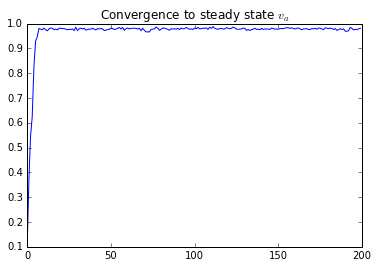

In [7]:
plt.plot(active.va_traj(ttraj))
plt.title('Convergence to steady state $v_a$')

In [8]:
vas = []
n = 40
nframes = 2000  # Need long time to get convergence
etas = np.linspace(0,5,15)
for eta in etas:
    ptraj, ttraj = active.run(n, rho, eta, vel, rcut, nframes, nlog)
    avg_order_param = np.mean(active.va_traj(ttraj)[200:])
    vas.append(avg_order_param)
    

In [121]:
%%time
vas2 = []
n = 400
nframes = 300
etas2 = np.linspace(0,5,15)
for eta in etas2:
    ptraj, ttraj = active.run(n, rho, eta, vel, rcut, nframes, nlog)
    avg_order_param = np.mean(active.va_traj(ttraj)[100:])
    vas2.append(avg_order_param)

CPU times: user 1min 10s, sys: 56 ms, total: 1min 10s
Wall time: 1min 10s


In [212]:
np.save?

In [ ]:
%%time
vas2 = []
n = 400
nframes = 300
etas2 = np.linspace(0,5,15)
for eta in etas2:
    ptraj, ttraj = active.run(n, rho, eta, vel, rcut, nframes, nlog)
    avg_order_param = np.mean(active.va_traj(ttraj)[100:])
    vas2.append(avg_order_param)

In [214]:
np.linspace(0,5,21)

array([ 0.  ,  0.25,  0.5 ,  0.75,  1.  ,  1.25,  1.5 ,  1.75,  2.  ,
        2.25,  2.5 ,  2.75,  3.  ,  3.25,  3.5 ,  3.75,  4.  ,  4.25,
        4.5 ,  4.75,  5.  ])

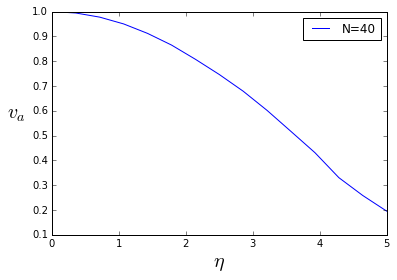

In [9]:
fig = plt.figure()
ax = fig.add_subplot(111)
ax.plot(etas, vas, label='N=40')
# ax.plot(etas2, vas2, label='N=400')
ax.legend()
ax.set_xlabel('$\eta$', fontsize=20)
ax.set_ylabel('$v_a$    ', fontsize=20, rotation=0)

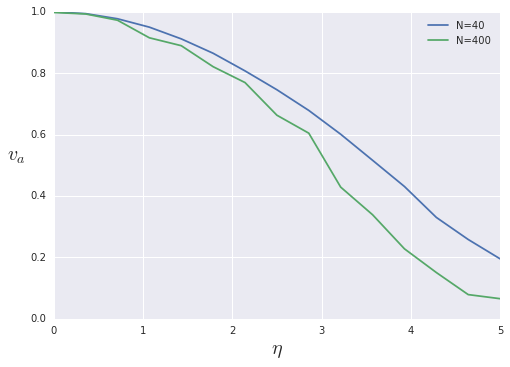

In [210]:
fig = plt.figure()
ax = fig.add_subplot(111)
ax.plot(etas, vas, label='N=40')
ax.plot(etas2, vas2, label='N=400')
ax.legend()
ax.set_xlabel('$\eta$', fontsize=20)
ax.set_ylabel('$v_a$    ', fontsize=20, rotation=0)

### Vicsek figure 3

Use non-linear optimization to fit parameters in model for second-order phase transition

First, a warm-up of using scipy.optimize

In [10]:
def f(xs, a, b, c):
    return a + b*xs**c

In [11]:
n=1000
xs = np.random.random(n)

In [12]:
ys = f(xs,3.,4.,5.) 
ysnoise = ys*np.random.uniform(.8,1.2,n)

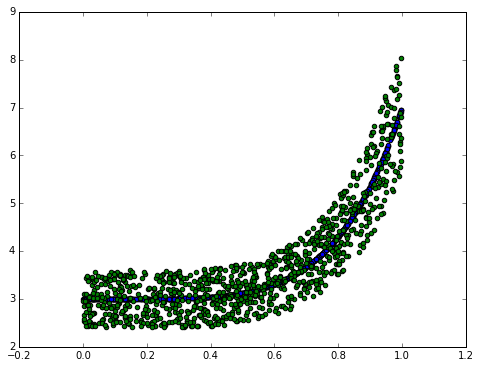

In [13]:
fig = plt.figure(figsize=(8,6))
ax = fig.add_subplot(111)
ax.scatter(xs, ys)
ax.scatter(xs, ysnoise, c='g')

In [14]:
def objective(params):
    a, b, c = params
    return np.sum(np.square(ysnoise - f(xs, a, b, c)))

In [15]:
initial_guess = np.array([4,5,6])
res = scipy.optimize.minimize(objective, initial_guess)

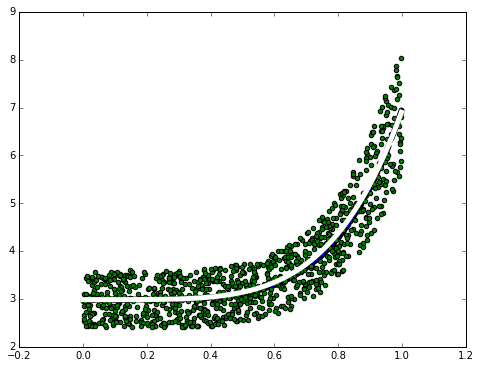

In [16]:
fig = plt.figure(figsize=(8,6))
ax = fig.add_subplot(111)
ax.scatter(xs, ys)
ax.scatter(xs, ysnoise, c='g')
linexs = np.linspace(min(xs), max(xs), 100)
ax.plot(linexs, f(linexs, *res['x']), lw=5, c='w', zorder=1)

### Now let's use this for the real calculation:

In [122]:
def f(etas, k, etac, beta):
#     etac = 2.9
    return k * (etac - etas)**beta

In [142]:
def objective(params):
#     etac = 2.9
    k, etac, beta = params
    etas_keep = etas[etas < etac]
    vas_keep = np.array(vas2)[etas < etac]    
    return np.sum(np.square(vas_keep - f(etas_keep, *params)))

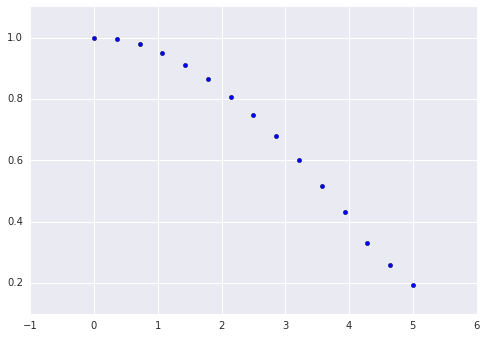

In [143]:
fig = plt.figure()
ax2 = fig.add_subplot(111)
ax2.scatter(etas, vas)

In [144]:
initial_guess = np.array([1, 2, .5])
# initial_guess = np.array([1, 1, 1])
res = scipy.optimize.minimize(objective, initial_guess)

In [145]:
res['x']

array([ 0.92293739,  2.14091253,  0.11227795])

TypeError: tuple indices must be integers, not str

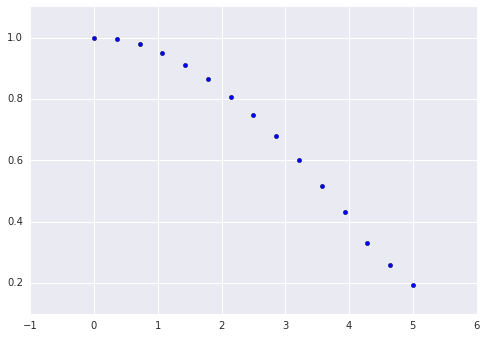

In [207]:
fig = plt.figure()
ax = fig.add_subplot(111)
ax.scatter(etas, vas)
etac = 3.
ax.plot(etas, f(etas, *res['x']))

In [204]:
np.abs(etac - etas)

array([ 3.        ,  2.64285714,  2.28571429,  1.92857143,  1.57142857,
        1.21428571,  0.85714286,  0.5       ,  0.14285714,  0.21428571,
        0.57142857,  0.92857143,  1.28571429,  1.64285714,  2.        ])

LinregressResult(slope=nan, intercept=nan, rvalue=nan, pvalue=nan, stderr=nan)

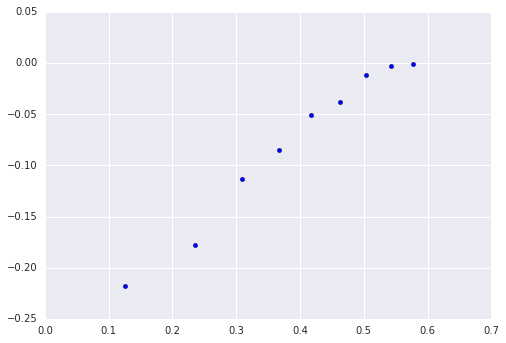

In [206]:
fig = plt.figure()
ax = fig.add_subplot(111)
etac = 3.
y = np.log10(vas2)
x = (etac - etas)**.5 / etac
ax.scatter(x,y)
# ax.set_ylim(.1,)
scipy.stats.linregress(x,y)

In [199]:
res = scipy.stats.linregress(x[~np.isnan(x)],y[~np.isnan(x)])
res

LinregressResult(slope=0.52111196943079652, intercept=-0.28287889227580088, rvalue=0.98889734313092648, pvalue=4.6971455950876934e-07, stderr=0.029597188695760036)

In [195]:
res.slope

0.52111196943079652